In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import seaborn as sns
import torch
from tqdm.notebook import tqdm

In [2]:
import sys
sys.path.append('../src')

In [3]:
from common.nb_utils import estimate_optimal_ncomponents, pca_transform

In [4]:
def projection(v1, v2):
    return torch.abs(
        (v1*v2).sum()/(v2*v2).sum()
    ).item()

def momentum_grad(prev_v, grad, momentum):
    return momentum * prev_v + grad

In [31]:
# hist_file = '../ckpts/mnist/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128.pkl'
# meta_file = '../ckpts/mnist/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128_processed_grads.pkl'

# hist_file = '../ckpts/cifar/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128.pkl'
# meta_file = '../ckpts/cifar/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128_processed_grads.pkl'

# hist_file = '../ckpts/cifar/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.1_decay_1e-05_batch_60000.pkl'
# meta_file = '../ckpts/cifar/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.1_decay_1e-05_batch_60000_processed_grads.pkl'

# hist_file = '../ckpts/cifar/history/clf_cnn_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128.pkl'
# meta_file = '../ckpts/cifar/history/clf_cnn_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128_processed_grads.pkl'

# hist_file = '../ckpts/fmnist/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128.pkl'
# meta_file = '../ckpts/fmnist/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_128_processed_grads.pkl'

# hist_file = '../ckpts/celeba/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.001_decay_1e-05_batch_256.pkl'
# meta_file = '../ckpts/celeba/history/clf_resnet18_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.001_decay_1e-05_batch_256_processed_grads.pkl'

# hist_file = '../ckpts/celeba/history/clf_cnn_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.001_decay_1e-05_batch_256.pkl'
# meta_file = '../ckpts/celeba/history/clf_cnn_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.001_decay_1e-05_batch_256_processed_grads.pkl'

hist_file = '../ckpts/voc/history/clf_unet_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.01_decay_1e-05_batch_32.pkl'
meta_file = '../ckpts/voc/history/clf_unet_optim_sgd_uniform_True_non_iid_0_num_workers_0_lr_0.001_decay_1e-05_batch_32_processed_grads.pkl'

In [32]:
h = pkl.load(open(hist_file, 'rb'))
# meta = pkl.load(open(meta_file, 'rb'))

In [21]:
mat_99 = meta['mat_99']
mat_95 = meta['mat_95']
overlap = meta['overlap_99']
overlap_self = meta['overlap_self']
l_params = meta['num_params']
num_layers = len(l_params)

In [33]:
epoch, train_acc, test_acc, train_loss, test_loss, grads = h

In [34]:
len(grads)

101

In [35]:
from models.unet import UNet

In [36]:
u = UNet(3, 22, 4)


In [38]:
i = 0
for name, layer in u.named_parameters():
    print(name, grads[100][i].sum().item())
    i += 1

conv_final.weight 1.9505580439727055e-07
conv_final.bias 2.0911102183163166e-08
down_blocks.0.conv1.weight 0.047452159225940704
down_blocks.0.conv1.bias -0.0032616956159472466
down_blocks.0.conv2.weight -0.3860335350036621
down_blocks.0.conv2.bias 0.0004946782137267292
down_blocks.0.norm1.weight 0.00031597225461155176
down_blocks.0.norm1.bias -0.0030599255114793777
down_blocks.0.norm2.weight 0.0019358975114300847
down_blocks.0.norm2.bias -0.00017601787112653255
down_blocks.1.conv1.weight -0.265485942363739
down_blocks.1.conv1.bias -0.001185053726658225
down_blocks.1.conv2.weight 0.38557571172714233
down_blocks.1.conv2.bias -0.0013501235516741872
down_blocks.1.norm1.weight 0.00011267181253060699
down_blocks.1.norm1.bias 0.00015059304132591933
down_blocks.1.norm2.weight 0.004048603121191263
down_blocks.1.norm2.bias -0.00046699849190190434
down_blocks.2.conv1.weight 0.3670225143432617
down_blocks.2.conv1.bias -0.0011356126051396132
down_blocks.2.conv2.weight 0.4175301194190979
down_blocks

# inter-grad overlap w/ momentum

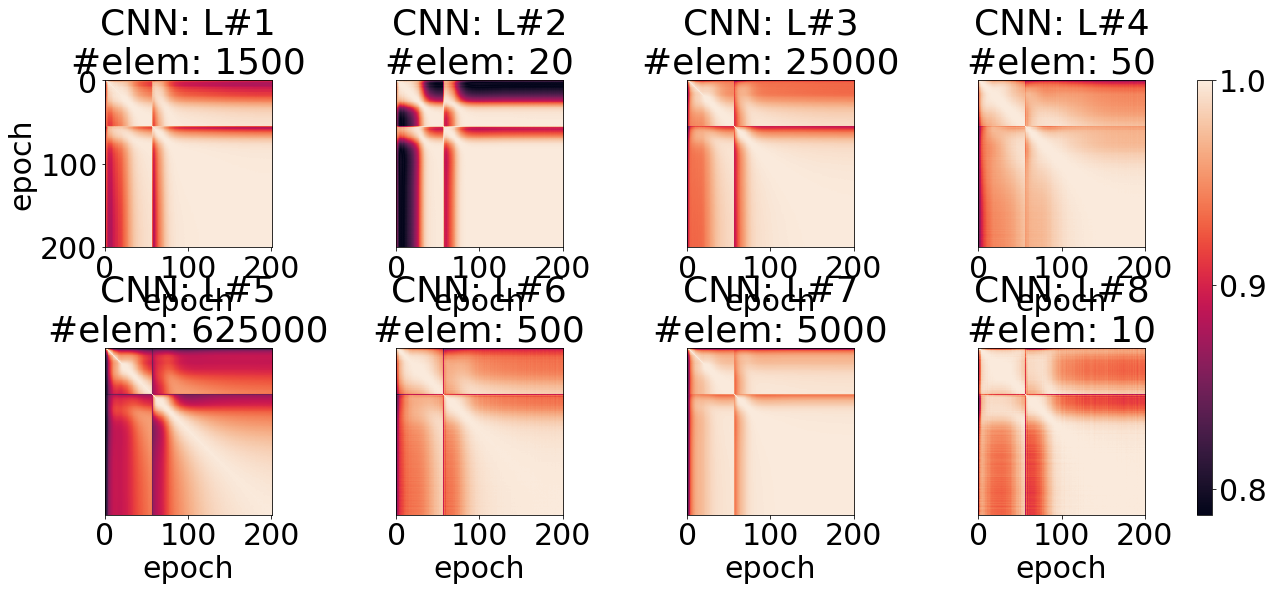

In [11]:
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7

cols = 4
rows = num_layers//cols
if num_layers%cols:
    rows += 1
fig = plt.figure(figsize=(5*cols, 4*rows))
n_epochs = mat_99.shape[0]


for layer_num, olap in tqdm(enumerate(overlap_self, 1), total=len(overlap_self)):
    ax = fig.add_subplot(rows, cols, layer_num)
    im = ax.imshow(np.abs(olap), cmap='rocket')
    ax.set_title('CNN: L#{}\n#elem: {}'.format(layer_num, l_params[layer_num-1]), pad=-10)
    ax.set_xticks(list(range(0, n_epochs, n_epochs//2)))
    
    if layer_num==1:
        ax.set_ylabel('epoch')
        ax.set_yticks(list(range(0, n_epochs, 100)))
    else:
        ax.set_yticks([])
    ax.set_xlabel('epoch')
    
cbar = fig.colorbar(im, ticks=[0.8, 0.9, 1], cax=fig.add_axes([0.91, 0.125, 0.01, 0.755]))
cbar.ax.set_yticklabels(['0.8', '0.9', '1.0'])
plt.subplots_adjust(hspace=0.6)
plt.show()

# pca-grad overlap w/ momentum

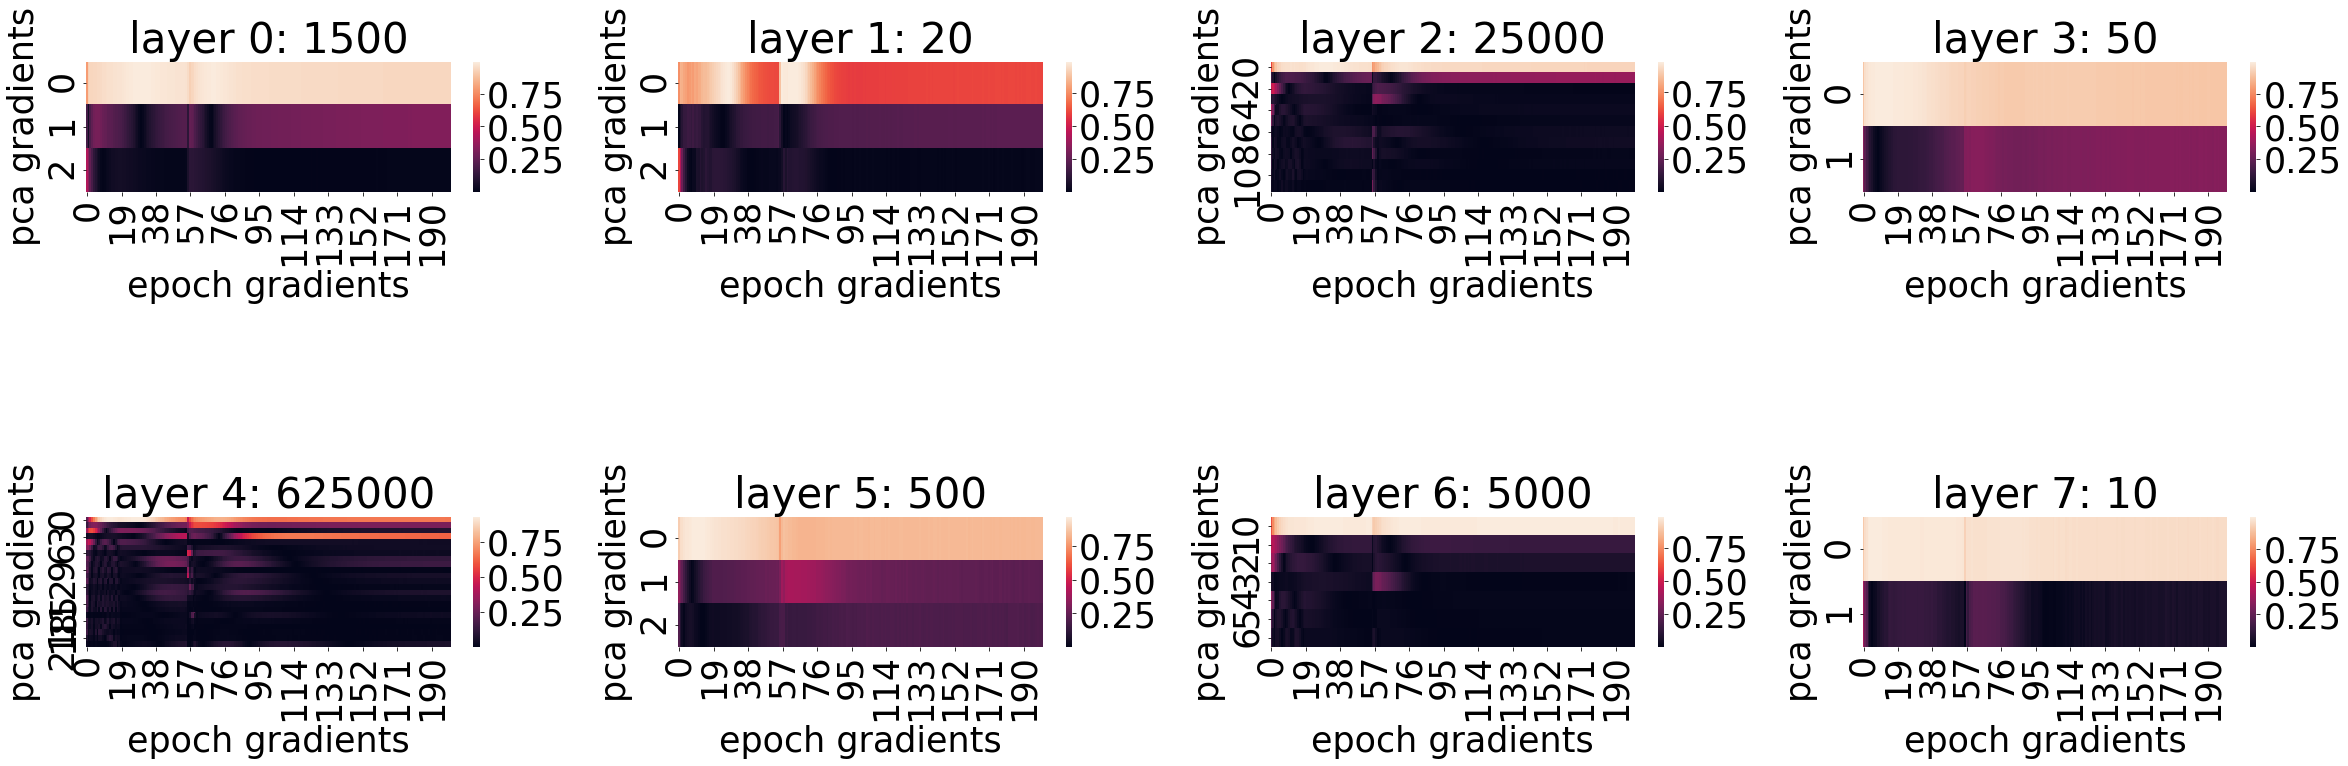

In [14]:
matplotlib.rcParams.update({'font.size': 35})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7

fig = plt.figure(figsize=(10*4, 64*2))
for idx, olap in tqdm(enumerate(overlap), total=len(overlap)):
    ax = fig.add_subplot(16, 4, idx+1)
    sns.heatmap(np.abs(olap), ax=ax)
    ax.set_xlabel('epoch gradients')
    ax.set_ylabel('pca gradients')
    ax.set_title('layer {}: {}'.format(idx, l_params[idx]))
plt.subplots_adjust(hspace=2.5, wspace=0.3)
plt.show()

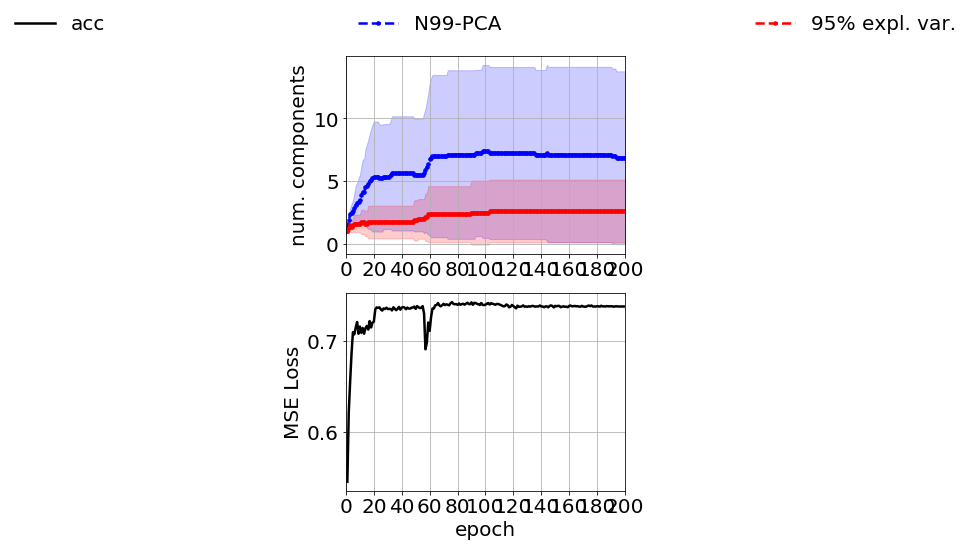

In [16]:
from matplotlib.ticker import FormatStrFormatter as Format
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7

fig = plt.figure(figsize=(5, 8))
ax2 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
ln1 = ax1.plot(epoch, np.array(test_acc), 'k', label='acc')

mu_99 = mat_99.mean(axis=1)
std_99 = mat_99.std(axis=1)
n_epochs = mat_99.shape[0]
# boxprops = dict(facecolor="b", color='k', alpha=0.5, linewidth=2.5)
# medianprops = dict(color="b",linewidth=2.5)
# whiskerprops = dict(color="k",linewidth=1.5)

# ax2.boxplot([mat_99[i] for i in range(0, mat_99.shape[0], 10)], 
#             positions=list(range(0, mat_99.shape[0], 10)), widths=[2.0]*11, 
#             showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)
ln2 = ax2.plot(epoch, mu_99, 'b.--', label='N99-PCA')
ax2.fill_between(epoch, mu_99-std_99, mu_99+std_99, color='b', alpha=0.2)

mu_95 = mat_95.mean(axis=1)
std_95 = mat_95.std(axis=1)
ln3 = ax2.plot(epoch, mu_95, 'r.--', label='95% expl. var.')
ax2.fill_between(epoch, mu_95-std_95, mu_95+std_95, color='r', alpha=0.2)
ax1.set_xlabel('epoch')
ax1.set_ylabel('MSE Loss')
ax2.set_ylabel('num. components')
plt.xlim(left=-0.5, right=mat_99.shape[0]+2)

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0, ncol=3, bbox_to_anchor=(-1.25, 1.15, 3.5, .15), mode='expand', frameon=False)

ax1.set_xticks(list(range(0, n_epochs, 20)))
ax2.set_xticks(list(range(0, n_epochs, 20)))
# ax2.yaxis.set_major_formatter(Format('%.1f'))
ax1.grid()
ax2.grid()
ax1.set_xlim(0, n_epochs-1)
ax2.set_xlim(0, n_epochs-1)

plt.show()

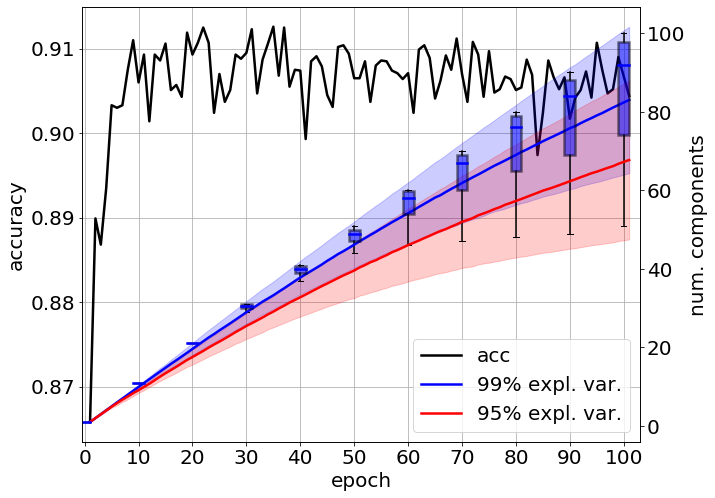

In [13]:
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ln1 = ax1.plot(epoch, np.array(test_acc), 'k', label='acc')

mu_99 = mat_99.mean(axis=1)
std_99 = mat_99.std(axis=1)
boxprops = dict(facecolor="b", color='k', alpha=0.5, linewidth=2.5)
medianprops = dict(color="b",linewidth=2.5)
whiskerprops = dict(color="k",linewidth=1.5)

ax2.boxplot([mat_99[i] for i in range(0, mat_99.shape[0], 10)], 
            positions=list(range(0, mat_99.shape[0], 10)), widths=[2.0]*11, 
            showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)
ln2 = ax2.plot(epoch, mu_99, color='b', label='99% expl. var.')
ax2.fill_between(epoch, mu_99-std_99, mu_99+std_99, color='b', alpha=0.2)

mu_95 = mat_95.mean(axis=1)
std_95 = mat_95.std(axis=1)
ln3 = ax2.plot(epoch, mu_95, color='r', label='95% expl. var.')
ax2.fill_between(epoch, mu_95-std_95, mu_95+std_95, color='r', alpha=0.2)
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('num. components')
plt.xlim(left=-0.5, right=mat_99.shape[0]+2)

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.grid()
plt.show()

In [25]:
l_params

{0: 1500, 1: 20, 2: 25000, 3: 50, 4: 625000, 5: 500, 6: 5000, 7: 10}

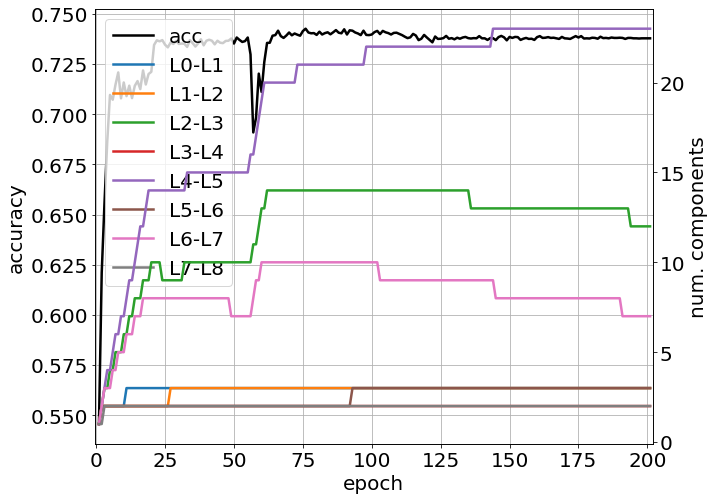

In [24]:
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['lines.markersize'] = 7
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
lns = ax1.plot(epoch, np.array(test_acc), 'k', label='acc')

intv = 1
for j in range(0, mat_99.shape[1], intv):
    mu_99 = mat_99[:, j:j+intv].mean(axis=1)
    std_99 = mat_99[:, j:j+intv].std(axis=1)
    lns += ax2.plot(epoch, mu_99, label='L{}-L{}'.format(j, j+intv))
    ax2.fill_between(epoch, mu_99-std_99, mu_99+std_99, alpha=0.2)

# ax2.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('num. components')

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)
ax1.grid()
plt.xlim(left=-0.5, right=mat_99.shape[0]+1)
plt.show()

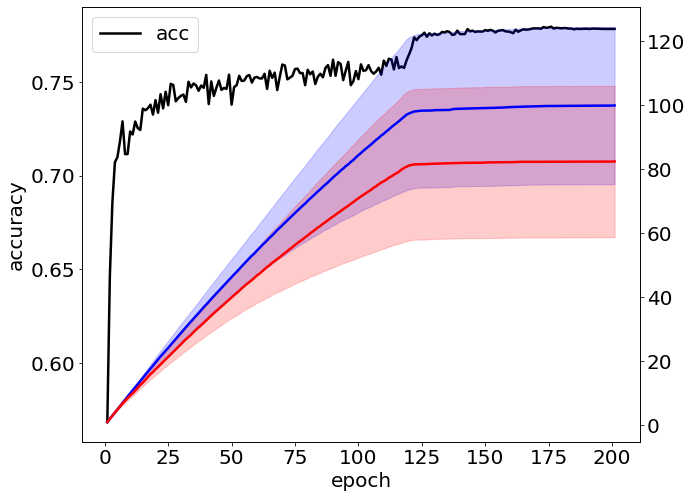

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(epoch, np.array(test_acc), 'k', label='acc')

mu_99 = mat_99.mean(axis=1)
std_99 = mat_99.std(axis=1)
ax2.plot(epoch, mu_99, color='b', label='99% expl. var.')
ax2.fill_between(epoch, mu_99-std_99, mu_99+std_99, color='b', alpha=0.2)

mu_95 = mat_95.mean(axis=1)
std_95 = mat_95.std(axis=1)
ax2.plot(epoch, mu_95, color='r', label='95% expl. var.')
ax2.fill_between(epoch, mu_95-std_95, mu_95+std_95, color='r', alpha=0.2)
ax1.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
# ax2.set_ylabel('num. components')
plt.show()